In [3]:
import gseapy as gp
import scanpy as sc
import networkx as nx
import scrublet as scr #für die doublet entfernung
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math

data_pfad = "data/emptydrops_all_detected_cells.h5ad"
#data_pfad = "data/filtered_feature_bc_matrix.h5"

/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [4]:
def load_data_and_preprocess(path):

    if path.endswith(".h5ad"):
        adata = sc.read_h5ad(path)
    else:
        adata = sc.read_10x_h5(path)

#    sc.pp.filter_genes(adata, min_cells=3)

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    return adata

Preprocessing...


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 20.0%
Elapsed time: 36.8 seconds
Total counts range: [ 274.58108521 1637.69580078 5670.17041016]
Genes/cell range: [   63.   602. 12675.]


<Figure size 1000x500 with 0 Axes>

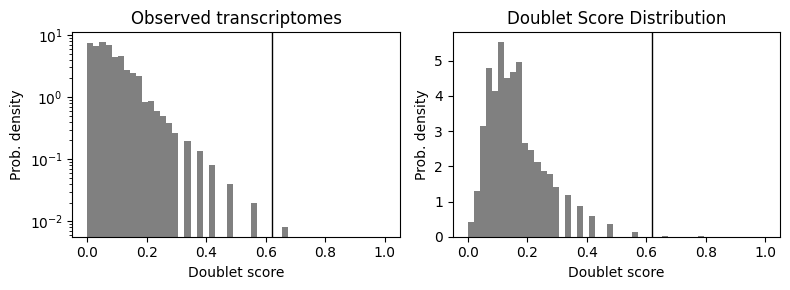

results: 
Threshold: 0.10, Removed: 4005 cells (32.5%) with score: 0.16
Threshold: 0.12, Removed: 2849 cells (23.1%) with score: 0.18
Threshold: 0.14, Removed: 2153 cells (17.5%) with score: 0.20
Threshold: 0.16, Removed: 1531 cells (12.4%) with score: 0.22
Threshold: 0.18, Removed: 981 cells (8.0%) with score: 0.25
Threshold: 0.21, Removed: 772 cells (6.3%) with score: 0.26
Threshold: 0.23, Removed: 409 cells (3.3%) with score: 0.30
Threshold: 0.25, Removed: 283 cells (2.3%) with score: 0.33
Threshold: 0.27, Removed: 283 cells (2.3%) with score: 0.33
Threshold: 0.29, Removed: 187 cells (1.5%) with score: 0.36
Threshold: 0.31, Removed: 120 cells (1.0%) with score: 0.39
Threshold: 0.33, Removed: 120 cells (1.0%) with score: 0.39
Threshold: 0.35, Removed: 71 cells (0.6%) with score: 0.42
Threshold: 0.37, Removed: 71 cells (0.6%) with score: 0.42
Threshold: 0.39, Removed: 37 cells (0.3%) with score: 0.47
Threshold: 0.42, Removed: 37 cells (0.3%) with score: 0.47
Threshold: 0.44, Removed: 

AnnData object with n_obs × n_vars = 12244 × 22040
    obs: 'emptydrops_detected', 'fdr_threshold', 'total_umi', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'filtering_info', 'log1p'

In [8]:
def auto_optimize_doublets_threshold():
    adata = load_data_and_preprocess(data_pfad)

    if adata.raw is None:
        adata.raw = adata  # Preserve raw counts



    # Initialize Scrublet with optimized parameters
    scrub = scr.Scrublet(
        adata.raw.X,
        expected_doublet_rate=0.06,  # Increased from 0.06
        sim_doublet_ratio=1.0,      # Increased from 2.0
        n_neighbors=30              # Added for better neighborhood estimation
    )

    # Calculate doublet scores with error handling
    try:
        doublet_scores, predicted_doublets = scrub.scrub_doublets(
            synthetic_doublet_umi_subsampling=1.0,
            use_approx_neighbors=False
        )
    except Exception as e:
        print(f"Scrublet failed: {str(e)}")
        # Fallback to simple UMI-based filtering
        top_umi = np.percentile(adata.obs['total_counts'], 95)
        adata = adata[adata.obs['total_counts'] < top_umi, :]
        return adata

    adata.obs['doublet_score'] = doublet_scores

    # print total counts range
    total_counts = np.array(adata.raw.X.sum(axis=1)).flatten()
    print(f"Total counts range: {np.percentile(total_counts, [0, 50, 100])}")
    n_genes = np.array((adata.raw.X > 0).sum(axis=1)).flatten()
    print(f"Genes/cell range: {np.percentile(n_genes, [0, 50, 100])}")

    # Plot histogram for manual inspection
    plt.figure(figsize=(10,5))
    scrub.plot_histogram()
    plt.title('Doublet Score Distribution')
    plt.show()

    # Threshold optimization with fallback
    thresholds = np.round(np.linspace(0.1, 0.5, 20), 2)  # Start from 0.1
    results = []
    
    for thresh in thresholds:
        mask = doublet_scores > thresh
        if mask.sum() > 0:
            results.append({
                'threshold': thresh,
                'n_doublets': mask.sum(),
                'mean_score': doublet_scores[mask].mean(),
                'percent_removed': 100 * mask.mean()
            })

    if not results:  # If no doublets found at any threshold
        print("No doublets detected at any threshold. Using conservative 0.15 cutoff.")
        conservative_thresh = 0.15
        results.append({
            'threshold': conservative_thresh,
            'n_doublets': (doublet_scores > conservative_thresh).sum(),
            'mean_score': doublet_scores[doublet_scores > conservative_thresh].mean(),
            'percent_removed': 100 * (doublet_scores > conservative_thresh).mean()
        })

    # Select threshold with highest mean score that removes at least 0.5% of cells
    optimal = max(
        [r for r in results if r['percent_removed'] > 0.5],
        key=lambda x: x['mean_score'],
        default=results[-1]  # Fallback to last threshold if none meet criteria
    )

    #pretty print each result on its own line
    print("results: ")
    for r in results:
        print(f"Threshold: {r['threshold']:.2f}, Removed: {r['n_doublets']} cells ({r['percent_removed']:.1f}%) with score: {r['mean_score']:.2f}")

    print(f"Selected threshold: {optimal['threshold']:.2f}")
    print(f"Removed {optimal['n_doublets']} cells ({optimal['percent_removed']:.1f}%), mean score: {optimal['mean_score']:.2f}")
    
    return adata[adata.obs['doublet_score'] <= optimal['threshold'], :].copy()

adata = auto_optimize_doublets_threshold()
adata

Preprocessing...


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 20.0%
Elapsed time: 39.5 seconds
Total counts range: [ 274.58108521 1637.69580078 5670.17041016]
Genes/cell range: [   63.   602. 12675.]


<Figure size 1000x500 with 0 Axes>

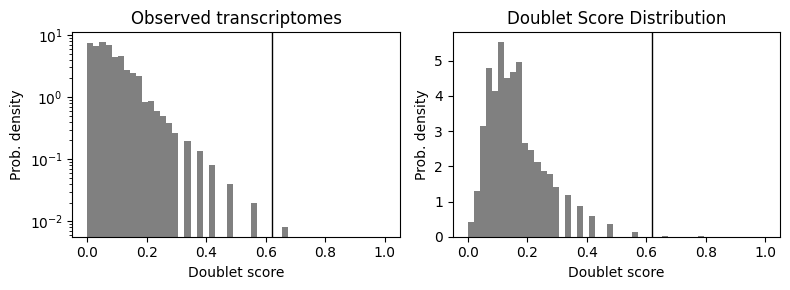

Using threshold: 0.35
Removed 71 cells (0.6%)

Analysis of 71 removed doublet cells:
UMI count ranks (out of 12315 total cells): [258, 890, 1436, 1499, 1509, 1568, 1754, 2118, 2165, 2777]...

Top 10 expressed genes for each doublet cell:

Doublet cell 1 (Rank: 4484, UMI: 2342, Score: 0.481):
  PRM1: 4.8
  INSL3: 4.7
  DHRS4: 4.5
  FSIP2: 4.4
  SPATA16: 4.4
  ADAM2: 4.4
  CTNND2: 4.1
  ADAM32: 4.1
  MACROD2: 4.1
  SGO2: 4.1

Doublet cell 2 (Rank: 5046, UMI: 2103, Score: 0.373):
  PRM1: 5.2
  INSL3: 5.0
  COX3: 4.5
  COX7A2: 4.4
  ATP6: 4.1
  HSPB9: 4.0
  ENSSSCG00000008170: 4.0
  RPL7A: 4.0
  COX1: 4.0
  ND1: 4.0

Doublet cell 3 (Rank: 5224, UMI: 2028, Score: 0.557):
  PRM1: 5.4
  P3H2: 4.5
  DLC1: 4.4
  PRKG1: 4.3
  TNP1: 4.1
  EPS8: 4.0
  ROCK2: 4.0
  CYP7B1: 4.0
  RBMS3: 4.0
  ATP6: 3.8

Doublet cell 4 (Rank: 7927, UMI: 1130, Score: 0.373):
  INSL3: 4.9
  BORCS5: 4.7
  CDKAL1: 4.4
  CYP17A1: 4.4
  CD63: 4.4
  ENSSSCG00000012842: 4.4
  EXOC6: 4.4
  GPX4: 4.4
  TNP1: 4.4
  OPHN1: 4.0



AnnData object with n_obs × n_vars = 12244 × 22040
    obs: 'emptydrops_detected', 'fdr_threshold', 'total_umi', 'doublet_score'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'filtering_info', 'log1p'

In [ ]:
def best_doublets_threshold_analysis(chosen_threshold):
    adata = load_data_and_preprocess(data_pfad)

    if adata.raw is None:
        adata.raw = adata  # Preserve raw counts

    # Initialize Scrublet with optimized parameters
    scrub = scr.Scrublet(
        adata.raw.X,
        expected_doublet_rate=0.06,  # Increased from 0.06
        sim_doublet_ratio=1.0,      # Increased from 2.0
        n_neighbors=30              # Added for better neighborhood estimation
    )

    # Calculate doublet scores with error handling
    try:
        doublet_scores, predicted_doublets = scrub.scrub_doublets(
            synthetic_doublet_umi_subsampling=1.0,
            use_approx_neighbors=False
        )
    except Exception as e:
        print(f"Scrublet failed: {str(e)}")
        # Fallback to simple UMI-based filtering
        top_umi = np.percentile(adata.obs['total_counts'], 95)
        adata = adata[adata.obs['total_counts'] < top_umi, :]
        return adata

    adata.obs['doublet_score'] = doublet_scores

    # print total counts range
    total_counts = np.array(adata.raw.X.sum(axis=1)).flatten()
    print(f"Total counts range: {np.percentile(total_counts, [0, 50, 100])}")
    n_genes = np.array((adata.raw.X > 0).sum(axis=1)).flatten()
    print(f"Genes/cell range: {np.percentile(n_genes, [0, 50, 100])}")

    # Plot histogram for manual inspection
    plt.figure(figsize=(10,5))
    scrub.plot_histogram()
    plt.title('Doublet Score Distribution')
    plt.show()

    doublet_mask = doublet_scores > chosen_threshold
    
    print(f"Using threshold: {chosen_threshold}")
    print(f"Removed {doublet_mask.sum()} cells ({100 * doublet_mask.mean():.1f}%)")
    
    # Extract the 71 doublet cells for analysis
    doublet_cells = adata[doublet_mask, :].copy()
    
    # Calculate total UMI counts for all cells and rank them
    all_umi_counts = np.array(adata.raw.X.sum(axis=1)).flatten()
    doublet_umi_counts = np.array(doublet_cells.raw.X.sum(axis=1)).flatten()
    
    # Create ranking based on total UMI counts (decreasing order)
    all_cells_ranked = np.argsort(all_umi_counts)[::-1]  # Descending order
    
    # Find ranks of doublet cells
    doublet_ranks = []
    for i, cell_idx in enumerate(np.where(doublet_mask)[0]):
        rank = np.where(all_cells_ranked == cell_idx)[0][0] + 1  # 1-based ranking
        doublet_ranks.append(rank)
    
    print(f"\nAnalysis of {doublet_mask.sum()} removed doublet cells:")
    print(f"UMI count ranks (out of {len(adata)} total cells): {sorted(doublet_ranks)[:10]}..." if len(doublet_ranks) > 10 else f"UMI count ranks: {sorted(doublet_ranks)}")
    
    # Get top 10 expressed genes for each doublet cell
    print(f"\nTop 10 expressed genes for each doublet cell:")
    
    for i in range(min(10, len(doublet_cells))):  # Show first 10 doublet cells
        cell_expression = doublet_cells.raw.X[i, :].toarray().flatten() if hasattr(doublet_cells.raw.X, 'toarray') else doublet_cells.raw.X[i, :]
        top_gene_indices = np.argsort(cell_expression)[::-1][:10]
        top_genes = [doublet_cells.var_names[idx] for idx in top_gene_indices]
        top_expressions = [cell_expression[idx] for idx in top_gene_indices]
        
        cell_rank = doublet_ranks[i]
        cell_umi = doublet_umi_counts[i]
        
        print(f"\nDoublet cell {i+1} (Rank: {cell_rank}, UMI: {cell_umi:.0f}, Score: {doublet_scores[np.where(doublet_mask)[0][i]]:.3f}):")
        for gene, expr in zip(top_genes, top_expressions):
            print(f"  {gene}: {expr:.1f}")
    
    if len(doublet_cells) > 10:
        print(f"\n... and {len(doublet_cells) - 10} more doublet cells")
    
    # Return filtered data without doublets
    return adata[~doublet_mask, :].copy()

# insert best threshold from above
adata = best_doublets_threshold_analysis(0.35)
adata

In [ ]:
import scanpy as sc
# open data folder and import h5ad files
# data_pfad = "data/emptydrops_all_detected_cells.h5ad"
adata = sc.read_h5ad("data/emptydrops_all_detected_cells.h5ad")
bdata = sc.read_10x_h5("data/emptydrops_all_detected_cells_cellbender.h5")
cdata = sc.read_10x_h5("data/filtered_feature_bc_matrix_cellbender.h5")


AnnData object with n_obs × n_vars = 12315 × 22040
    obs: 'emptydrops_detected', 'fdr_threshold', 'total_umi'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'filtering_info'


/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/oskarhaupt/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2701 × 22040
    var: 'gene_ids', 'feature_types', 'genome'

In [6]:
print("adata: -----------", adata)
adata.obs['total_umi_counts'] = adata.X.sum(axis=1).A1 if hasattr(adata.X, 'A1') else adata.X.sum(axis=1)
print(f"adata UMI counts - Mean: {adata.obs['total_umi_counts'].mean():.0f}, Median: {adata.obs['total_umi_counts'].median():.0f}")

print("bdata: -----------", bdata)
bdata.obs['total_umi_counts'] = bdata.X.sum(axis=1).A1 if hasattr(bdata.X, 'A1') else bdata.X.sum(axis=1)
print(f"bdata UMI counts - Mean: {bdata.obs['total_umi_counts'].mean():.0f}, Median: {bdata.obs['total_umi_counts'].median():.0f}")

print("cdata: -----------", cdata)
cdata.obs['total_umi_counts'] = cdata.X.sum(axis=1).A1 if hasattr(cdata.X, 'A1') else cdata.X.sum(axis=1)
print(f"cdata UMI counts - Mean: {cdata.obs['total_umi_counts'].mean():.0f}, Median: {cdata.obs['total_umi_counts'].median():.0f}")

adata: ----------- AnnData object with n_obs × n_vars = 12315 × 22040
    obs: 'emptydrops_detected', 'fdr_threshold', 'total_umi', 'total_umi_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'filtering_info'
adata UMI counts - Mean: 2490, Median: 860
bdata: ----------- AnnData object with n_obs × n_vars = 12315 × 22040
    var: 'gene_ids', 'feature_types', 'genome'
bdata UMI counts - Mean: 1078, Median: 0
cdata: ----------- AnnData object with n_obs × n_vars = 2701 × 22040
    var: 'gene_ids', 'feature_types', 'genome'
cdata UMI counts - Mean: 1342, Median: 0
